# 🧢 Predicting MLB Home Runs Using Statcast Data

This project explores whether we can predict if a batted ball will become a home run based on its characteristics (launch angle, exit velocity, etc.).

We use real MLB data from Baseball Savant to build a logistic regression model that predicts whether a player will hit at least one home run based on swing-related metrics.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set(style = 'whitegrid')
pd.set_option('display.max_columns',None)

## 🧹 Data Cleaning
- Created Binary target column (is_hr)
- Filled Missing values using column means
- Dropped irrelvent columns   

In [2]:
df = pd.read_csv('../data/savant_data.csv')

print(f"Data Shape: {df.shape}")

df.head()
df.tail()

Data Shape: (494, 70)


,pitches,player_id,player_name,total_pitches,pitch_percent,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,spin_rate,velocity,effective_speed,whiffs,swings,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance,pitcher_run_exp,run_exp,bat_speed,swing_length,pa,bip,singles,doubles,triples,hrs,so,k_percent,bb,bb_percent,api_break_z_with_gravity,api_break_z_induced,api_break_x_arm,api_break_x_batter_in,hyper_speed,bbdist,hardhit_percent,barrels_per_bbe_percent,barrels_per_pa_percent,release_pos_z,release_pos_x,plate_x,plate_z,obp,barrels_total,batter_run_value_per_100,xobp,xslg,pitcher_run_value_per_100,xbadiff,xobpdiff,xslgdiff,wobadiff,swing_miss_percent,arm_angle
489,7,678894,"Peguero, Liover",7,100,0.333,0.0,0.333,0.333,0.298,0.285,0.313,1,3,102.0,-14.7,2036,92.7,93.21,0,4,3,0.5,6.53,113,153,106,148,309,325,293,0.180,-0.180,71.6,7.0,3,3,1,0,0,0,0,0.0,0,0.0,1.58286,1.06571,0.57714,-0.57714,98.5,71.0,100.0,0.0,0.0,6.39,0.32,-0.46,1.92,0.333,0,-2.571429,0.313,0.339,2.571429,0.020,0.020,-0.006,0.013,0.0,NaN
490,5,607067,"Rea, Colin",5,100,0.000,0.0,NaN,0.000,0.000,0.000,NaN,0,1,NaN,NaN,1928,80.9,79.00,0,3,2,-1.9,5.14,116,152,124,149,307,333,299,0.457,-0.457,60.0,6.6,1,0,0,0,0,0,1,100.0,0,0.0,2.66400,0.88600,1.07800,1.07800,88.0,129.0,NaN,NaN,0.0,5.83,-1.01,0.15,2.95,0.000,0,-9.140000,NaN,NaN,9.140000,NaN,NaN,NaN,0.000,0.0,28.2
491,5,680118,"Blanco, Dairon",5,100,0.000,0.0,0.000,0.000,0.000,0.093,0.100,0,1,72.9,-6.0,1628,80.1,81.60,2,3,2,1.5,7.22,107,155,110,149,310,312,298,-0.484,0.484,71.5,8.1,1,1,0,0,0,0,0,0.0,0,0.0,2.58200,1.00800,1.00200,-1.00200,88.0,13.0,0.0,0.0,0.0,5.92,0.26,-0.05,3.18,0.000,0,9.680000,0.100,0.115,-9.680000,-0.100,-0.100,-0.115,-0.093,66.7,53.6
492,5,694359,"Kavadas, Niko",5,100,0.000,0.0,0.000,0.000,0.000,0.025,0.017,0,1,84.9,47.0,1954,94.5,93.70,0,2,3,-0.8,6.20,118,147,124,153,304,332,310,0.263,-0.263,70.2,7.2,1,1,0,0,0,0,0,0.0,0,0.0,2.15600,0.43600,1.42600,-1.42600,88.0,228.0,0.0,0.0,0.0,5.63,-2.80,0.34,2.64,0.000,0,-5.260000,0.017,0.037,5.260000,-0.017,-0.017,-0.037,-0.025,0.0,33.5
493,4,669194,"Nelson, Ryne",4,100,1.000,0.0,1.000,1.000,0.895,0.158,0.143,1,1,89.8,-17.0,2326,89.6,90.00,0,1,3,0.4,6.63,88,122,81,138,294,310,269,-0.538,0.538,75.8,7.1,1,1,1,0,0,0,0,0.0,0,0.0,1.65000,1.20500,0.61250,0.61250,89.8,10.0,0.0,0.0,0.0,5.64,-0.32,0.64,2.61,1.000,0,13.450000,0.143,0.194,-13.450000,0.857,0.857,0.806,0.737,0.0,48.0


In [3]:
columns_to_drop = ['pitches', 'total_pitches', 'pitch_percent',
                   'spin_rate', 'velocity', 'effective_speed', 'whiffs', 'swings', 'takes',
                   'eff_min_vel', 'release_extension', 'pos3_int_start_distance', 
                   'pos4_int_start_distance', 'pos5_int_start_distance', 'pos6_int_start_distance',
                   'pos7_int_start_distance', 'pos8_int_start_distance', 'pos9_int_start_distance',
                   'api_break_z_with_gravity', 'api_break_z_induced', 'api_break_x_arm',
                   'api_break_x_batter_in', 'release_pos_z', 'release_pos_x', 'plate_x', 
                   'plate_z', 'pitcher_run_exp', 'pitcher_run_value_per_100']

df = df.drop(columns=columns_to_drop)

# Checking for Null Values 
df.isnull().sum().sort_values(ascending=False)

# Creating Binary Target Columns to Check Homeruns
df['is_hr'] = df['hrs'].apply(lambda x: 1 if x > 0 else 0)


In [4]:
# Checking for Null Values 
df.isnull().sum().sort_values(ascending=False)

# After Checking we Have Arm Angle and BABIP having 5 null values, 
# anything with under 5 missing values will result in the mean being applied 

arm_angle                   5
babip                       5
launch_speed                4
xslgdiff                    4
xba                         4
xbadiff                     4
xslg                        4
hardhit_percent             4
launch_angle                4
barrels_per_bbe_percent     4
xobpdiff                    3
xobp                        3
hyper_speed                 1
bbdist                      1
obp                         0
barrels_per_pa_percent      0
player_id                   0
barrels_total               0
batter_run_value_per_100    0
bb                          0
wobadiff                    0
swing_miss_percent          0
bb_percent                  0
hrs                         0
k_percent                   0
run_exp                     0
ba                          0
iso                         0
slg                         0
woba                        0
xwoba                       0
hits                        0
abs                         0
bat_speed 

In [5]:
df = df.fillna(df.mean(numeric_only=True))
df.isnull().sum().sum()  

np.int64(0)

In [6]:
# Creating Binary Target Columns to Check Homeruns
df['is_hr'] = df['hrs'].apply(lambda x: 1 if x > 0 else 0)

## 📖 Data Dictionary


- `player_id` - Each player’s unique ID  
- `player_name` - Player's first and last name  
- `ba` - Batting Average (hits / at-bats)  
- `iso` - Isolated Power (SLG - BA), measuring raw power from the batter  
- `babip` - Batting Average on Balls In Play  
- `slg` - Slugging Percentage (total bases / at-bats)  
- `woba` - Weighted On-Base Average (overall offensive value)  
- `xwoba` - Expected Weighted On-Base Average based on quality of contact  
- `xba` - Expected Batting Average based on launch metrics  
- `hits` - Total number of hits  
- `abs` - Total number of at-bats  
- `launch_speed` - Average exit velocity of batted balls (mph)  
- `launch_angle` - Average vertical launch angle (degrees)  
- `run_exp` - Expected runs created from contact quality  
- `bat_speed` - Speed of the bat at the moment of contact (mph)  
- `swing_length` - Length of the batter’s swing (inches)  
- `pa` - Total plate appearances  
- `bip` - Balls put in play  
- `singles` - Number of singles hit  
- `doubles` - Number of doubles hit  
- `triples` - Number of triples hit  
- `hrs` - Number of home runs hit  
- `so` - Total strikeouts  
- `k_percent` - Strikeout percentage  
- `bb` - Total walks (base on balls)  
- `bb_percent` - Walk percentage  
- `hyper_speed` - Player’s sprint speed during batted ball events  
- `bbdist` - Average distance (feet) of batted balls  
- `hardhit_percent` - % of batted balls hit at 95+ mph  
- `barrels_per_bbe_percent` - % of barreled balls per batted ball event  
- `barrels_per_pa_percent` - % of barreled balls per plate appearance  
- `obp` - On-base percentage (times on base / plate appearances)  
- `barrels_total` - Total number of barrels hit  
- `batter_run_value_per_100` - Run value added per 100 pitches seen  
- `xobp` - Expected on-base percentage  
- `xslg` - Expected slugging percentage  
- `xbadiff` - Difference between actual and expected batting average  
- `xobpdiff` - Difference between actual and expected on-base percentage  
- `xslgdiff` - Difference between actual and expected slugging percentage  
- `wobadiff` - Difference between actual and expected wOBA  
- `swing_miss_percent` - Percentage of swings that missed  
- `arm_angle` - Arm angle at point of contact  
- `is_hr` - **Target variable**: 1 = player hit at least one home run, 0 = no home runs  


In [7]:
FEATURES = df.columns.tolist()

FEATURES

['player_id',
 'player_name',
 'ba',
 'iso',
 'babip',
 'slg',
 'woba',
 'xwoba',
 'xba',
 'hits',
 'abs',
 'launch_speed',
 'launch_angle',
 'run_exp',
 'bat_speed',
 'swing_length',
 'pa',
 'bip',
 'singles',
 'doubles',
 'triples',
 'hrs',
 'so',
 'k_percent',
 'bb',
 'bb_percent',
 'hyper_speed',
 'bbdist',
 'hardhit_percent',
 'barrels_per_bbe_percent',
 'barrels_per_pa_percent',
 'obp',
 'barrels_total',
 'batter_run_value_per_100',
 'xobp',
 'xslg',
 'xbadiff',
 'xobpdiff',
 'xslgdiff',
 'wobadiff',
 'swing_miss_percent',
 'arm_angle',
 'is_hr']

In [8]:
REFPATH = "baseball_metrics_simplified_reference.csv"

DESCRIPTORS = [
    "Unique identifier for each player",
    "Full name of the player",
    "Batting average (hits divided by at-bats)",
    "Isolated power (slugging minus batting average, measures raw power)",
    "Batting average on balls in play",
    "Slugging percentage (total bases per at-bat)",
    "Weighted on-base average (measures overall offensive performance)",
    "Expected weighted on-base average based on contact quality",
    "Expected batting average based on launch angle and exit velocity",
    "Total number of hits",
    "Total number of at-bats",
    "Average exit velocity of batted balls (in mph)",
    "Average launch angle of batted balls (in degrees)",
    "Expected runs generated from batted ball events",
    "Average speed of the bat at contact (in mph)",
    "Swing length (in inches)",
    "Total number of plate appearances",
    "Number of balls put in play",
    "Number of singles hit",
    "Number of doubles hit",
    "Number of triples hit",
    "Number of home runs hit",
    "Total strikeouts",
    "Strikeout percentage",
    "Total walks (base on balls)",
    "Walk percentage",
    "Player's sprint speed during batted ball events",
    "Average distance of batted balls (in feet)",
    "Percentage of batted balls hit at 95+ mph",
    "Percentage of barrels per batted ball event",
    "Percentage of barrels per plate appearance",
    "On-base percentage (reaching base per plate appearance)",
    "Total number of barrels hit",
    "Run value generated per 100 pitches",
    "Expected on-base percentage",
    "Expected slugging percentage",
    "Difference between actual and expected batting average",
    "Difference between actual and expected on-base percentage",
    "Difference between actual and expected slugging percentage",
    "Difference between actual and expected wOBA",
    "Percentage of swings that resulted in misses",
    "Arm angle of the batter at contact",
    "Target: 1 if the player hit at least one home run, otherwise 0"
]

    

In [9]:
# @title
def operate_data_dictionary(features, descriptors, method="set", refpath=None):
  """ Operational function to work in creating or getting data dictionary. """
  if method == "set":
    # Produce dictionary-wrapped key-value associations of feature summaries
    data_dictionary = dict(zip(FEATURES, DESCRIPTORS))
    # Convert data dictionary to cleaner reference table
    reference = pd.DataFrame(data_dictionary, index=[0])
    # Save reference table for future access
    if refpath is not None and type(refpath) == str:
      reference.to_csv(refpath, index=False)
  if method == "get":
    # Get reference table from saved data dictionary
    if refpath is not None and type(refpath) == str:
      return pd.read_csv(refpath)
    else:
      raise TypeError("Saved file for data dictionary not found.")

def encode_categorical_feature(df, feature, encoding="label"):
  """ Custom function to encode categorical features using label-schema. """
  # Instantiate encoder architecture
  if encoding == "label":
    encoder = LabelEncoder()
  # Transform dataset feature using labeling schema (performs in-place)
  df[feature] = encoder.fit_transform(df[feature])
  # Get fitted encoder (just in case)
  return encoder

In [10]:
# Set data dictionary as reference table
operate_data_dictionary(features=FEATURES,
                        descriptors=DESCRIPTORS,
                        method="set",
                        refpath=REFPATH)

In [11]:
reference = operate_data_dictionary(features=FEATURES,
                                    descriptors=DESCRIPTORS,
                                    method="get",
                                    refpath=REFPATH)

In [12]:
reference.T

,0
player_id,Unique identifier for each player
player_name,Full name of the player
ba,Batting average (hits divided by at-bats)
iso,Isolated power (slugging minus batting average...
babip,Batting average on balls in play
slg,Slugging percentage (total bases per at-bat)
woba,Weighted on-base average (measures overall off...
xwoba,Expected weighted on-base average based on con...
xba,Expected batting average based on launch angle...
hits,Total number of hits


#  📊 Exploratory Data Analysis


### 1.) 🏟️ Home Run Distribution

In [13]:
dataset_hr = df.sort_values('hrs', ascending= False).head(10)

dataset_hr.head()

,player_id,player_name,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,run_exp,bat_speed,swing_length,pa,bip,singles,doubles,triples,hrs,so,k_percent,bb,bb_percent,hyper_speed,bbdist,hardhit_percent,barrels_per_bbe_percent,barrels_per_pa_percent,obp,barrels_total,batter_run_value_per_100,xobp,xslg,xbadiff,xobpdiff,xslgdiff,wobadiff,swing_miss_percent,arm_angle,is_hr
17,663728,"Raleigh, Cal",0.246,0.331,0.256,0.577,0.401,0.400,0.253,32,130,91.8,21.0,11.328,72.4,7.7,152,90,13,7,0,12,40,26.3,20,13.2,93.6,183.0,47.777778,22.222222,13.157895,0.355,20,1.759006,0.361,0.582,-0.007,-0.006,-0.005,0.001,29.9,38.4,1
11,656941,"Schwarber, Kyle",0.258,0.331,0.253,0.589,0.428,0.434,0.270,32,124,94.2,17.6,16.887,73.9,7.5,154,91,16,3,1,12,33,21.4,26,16.9,94.7,172.0,60.439560,15.384615,9.090909,0.403,14,2.531784,0.413,0.614,-0.012,-0.010,-0.025,-0.006,29.6,38.8,1
36,592450,"Judge, Aaron",0.414,0.346,0.484,0.759,0.531,0.498,0.351,55,133,95.6,15.9,23.861,74.4,8.1,153,102,33,9,2,11,31,20.3,18,11.8,95.1,183.0,56.862745,23.529412,15.686275,0.490,24,3.950497,0.436,0.762,0.063,0.054,-0.003,0.033,28.9,38.7,1
1,695578,"Wood, James",0.271,0.279,0.322,0.550,0.403,0.395,0.256,38,140,92.9,2.9,8.504,73.1,7.5,164,97,19,9,0,10,43,26.2,23,14.0,93.6,143.0,54.639175,17.525773,10.365854,0.378,17,1.160164,0.366,0.563,0.015,0.012,-0.013,0.008,27.8,35.8,1
33,553993,"Suárez, Eugenio",0.202,0.271,0.198,0.473,0.328,0.364,0.231,26,129,92.9,23.8,2.429,70.2,7.8,145,91,11,5,0,10,39,26.9,12,8.3,93.2,174.0,57.142857,16.483516,10.344828,0.283,15,0.398851,0.314,0.530,-0.029,-0.031,-0.057,-0.036,30.8,37.5,1


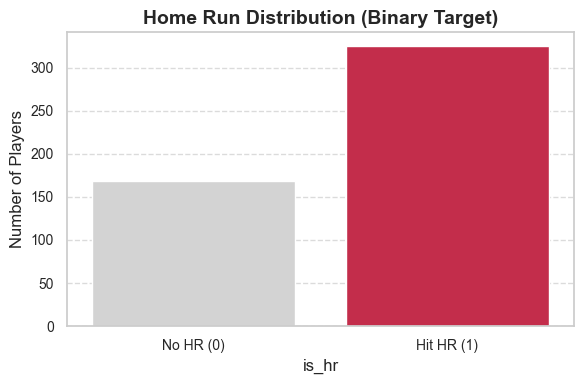

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='is_hr', hue='is_hr', data=df, palette={0: 'lightgray', 1: 'crimson'}, legend=False)

plt.title('Home Run Distribution (Binary Target)', fontsize=14, fontweight='bold')
plt.ylabel('Number of Players', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No HR (0)', 'Hit HR (1)'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 2.) How do key launch metrics (launch_speed, launch_angle, bbdist) differ between HR and non-HR groups? 

In [15]:
homerun_group = df.groupby('is_hr')[['launch_speed', 'launch_angle','bbdist']].mean()

print(homerun_group)

       launch_speed  launch_angle      bbdist
is_hr                                        
0         85.493870      9.920423  141.128365
1         89.137538     13.708923  157.187692


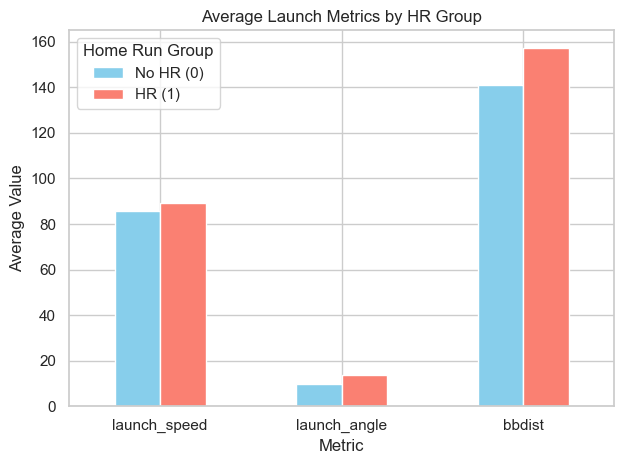

In [16]:
# Transpose the DataFrame so metrics are on X-axis
homerun_group.T.plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Average Launch Metrics by HR Group')
plt.ylabel('Average Value')
plt.xlabel('Metric')
plt.legend(title='Home Run Group', labels=['No HR (0)', 'HR (1)'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### - Summarized Metrics 

#### The chart shows a clear difference in homerun metrics. With homerun hitters have a: 
    - higher launch speed (~89 mph vs. ~85 mph), 
    - higher launch angle (~13.7° vs. ~9.9°), 
    - greater batted ball distance (~157 ft vs. ~141 ft).

#### The differences can be strong predicttors of home run likeihood and should be considered key features in the machine learning model.

### 3.) What features are most correlated with homeruns? 

In [17]:
swing_features = [
    'launch_speed',         
    'launch_angle',           
    'bat_speed',              
    'swing_length',          
    'bbdist',                
    'hardhit_percent',        
    'barrels_per_bbe_percent',
    'barrels_per_pa_percent', 
    'barrels_total',         
    'swing_miss_percent',     
    'arm_angle',
    'slg',
    'ba',
    'iso',
    
]
correlations = df[swing_features + ['is_hr']].corr()['is_hr'].drop('is_hr').sort_values(ascending=False)



/var/folders/6t/7rsnpsl57gs140xc9md0hw1r0000gn/T/ipykernel_45898/2300109725.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=correlations.values, y=correlations.index, palette='Spectral')


FileNotFoundError: [Errno 2] No such file or directory: 'images/correlation.png'

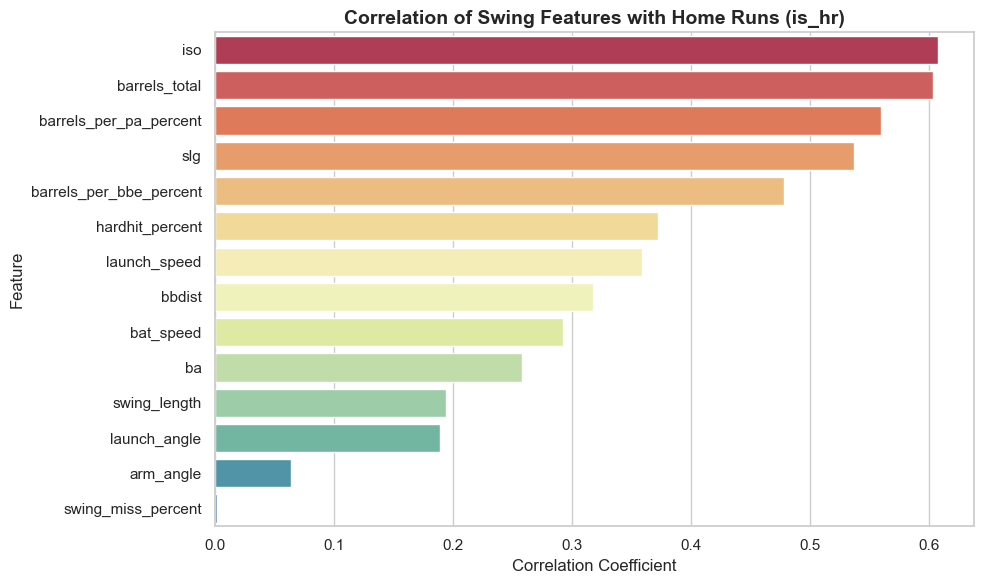

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=correlations.values, y=correlations.index, palette='Spectral')



# Titles and labels
plt.title('Correlation of Swing Features with Home Runs (is_hr)', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
plt.savefig("correlation.png")  

### Strongest Correlations: 
    Iso 
    barrels_total 
    barrels_per_pa_percent 
    slg 

#### Low Correlation for Launch Angle 
     - The perfect launch angle of arond 25 - 35 degrees will only exit a ballpark if hit with a large enough exit velocity. Which we see with launch speed only having a .35 correlation. 

#### Barrels-Total is the combinued optimal angle and speed, outpreforming something like showing launch_angle or exit velosity. 

### 4.) How balance is our target variable is_hr? 

In [ ]:
dataset_count = df['is_hr'].value_counts(normalize=True)

#df['is_hr'].value_counts(normalize=True)

print(dataset_count)

is_hr
1    0.657895
0    0.342105
Name: proportion, dtype: float64


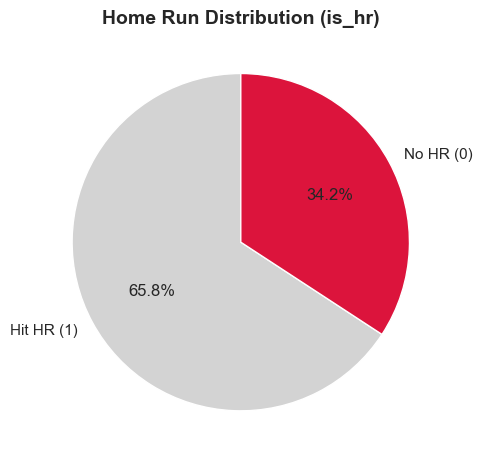

In [ ]:
labels = ['Hit HR (1)', 'No HR (0)']
fig, ax = plt.subplots()
ax.pie(dataset_count, labels=labels, autopct='%1.1f%%', colors=['lightgray', 'crimson'], startangle=90)
ax.set_title('Home Run Distribution (is_hr)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### The target variable is fairly balanced with 66% of players hitting at least one homerun, while the remaining have not.

#### This suggests that we can train a machine learning model without needing to resample or adjust the data we have.

### 5.) Can we see any outliers in our data? 

#### To make this easy we are going to look at the max and min of each column in the dataset 


In [ ]:
df.describe().loc[['min', 'max']]


,player_id,ba,iso,babip,slg,woba,xwoba,xba,hits,abs,launch_speed,launch_angle,run_exp,bat_speed,swing_length,pa,bip,singles,doubles,triples,hrs,so,k_percent,bb,bb_percent,hyper_speed,bbdist,hardhit_percent,barrels_per_bbe_percent,barrels_per_pa_percent,obp,barrels_total,batter_run_value_per_100,xobp,xslg,xbadiff,xobpdiff,xslgdiff,wobadiff,swing_miss_percent,arm_angle,is_hr
min,455117.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,1.0,57.8,-48.3,-12.180,51.6,5.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,10.0,0.0,0.0,0.000000,0.0,0.0,-9.140000,0.000,0.00,-0.210,-0.210,-0.506,-0.271,0.0,8.0,0.0
max,810938.0,1.0,1.0,1.0,1.333,0.895,0.663,0.608,55.0,159.0,102.0,73.0,23.861,78.2,8.5,179.0,133.0,38.0,14.0,4.0,12.0,48.0,100.0,30.0,40.0,98.5,250.0,100.0,100.0,33.333333,1.0,24.0,13.905556,0.608,1.27,0.857,0.857,0.867,0.737,71.4,53.6,1.0


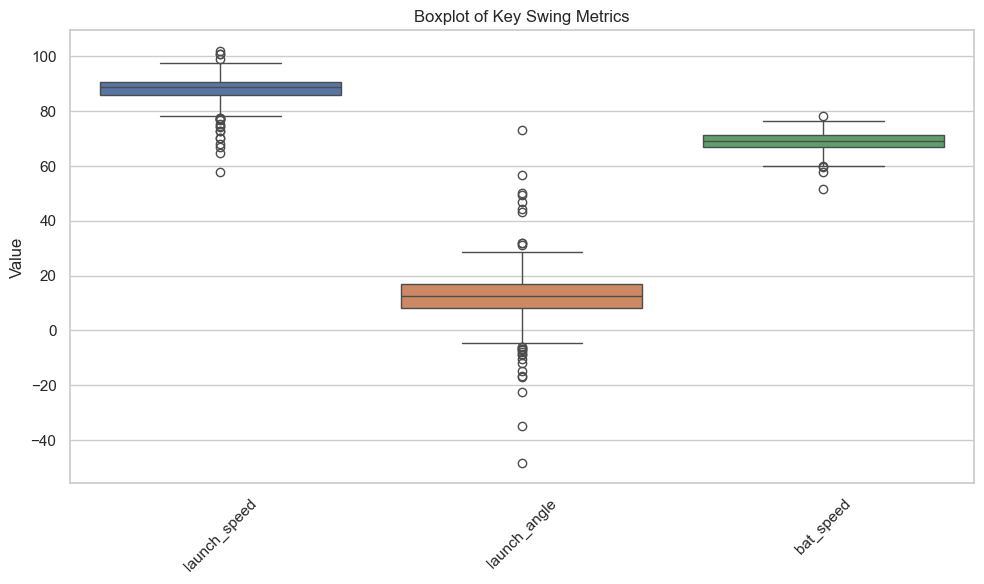

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['launch_speed', 'launch_angle', 'bat_speed']])
plt.title('Boxplot of Key Swing Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Many of the correlating stats have close distribution; the widest spread of the three is `launch_angle`. Due to things like pop-ups or topped hits, launch angle alone can be inconsistent. Although it can be helpful in determining home runs, its lack of strong correlation and its variation—often depending on other factors like bat speed and barrel connection—make it a less reliable standalone predictor.

# Machine Learning Part

### Defining x and y 

In [ ]:
x = df[swing_features]
y= df["is_hr"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state = 42)

In [ ]:
model = LogisticRegression(max_iter=2000)

model.fit(x_train, y_train)

LogisticRegression(max_iter=2000)

In [ ]:
y_prediction = model.predict(x_test) 

print(confusion_matrix(y_test, y_prediction))
print(classification_report(y_test, y_prediction))

[[27  1]
 [14 57]]
              precision    recall  f1-score   support

           0       0.66      0.96      0.78        28
           1       0.98      0.80      0.88        71

    accuracy                           0.85        99
   macro avg       0.82      0.88      0.83        99
weighted avg       0.89      0.85      0.86        99



In [ ]:
coefficients = pd.Series(model.coef_[0], index=x.columns)
coefficients = coefficients.sort_values(ascending=False)

/var/folders/6t/7rsnpsl57gs140xc9md0hw1r0000gn/T/ipykernel_46028/2698757608.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients.values, y=coefficients.index, palette='crest')


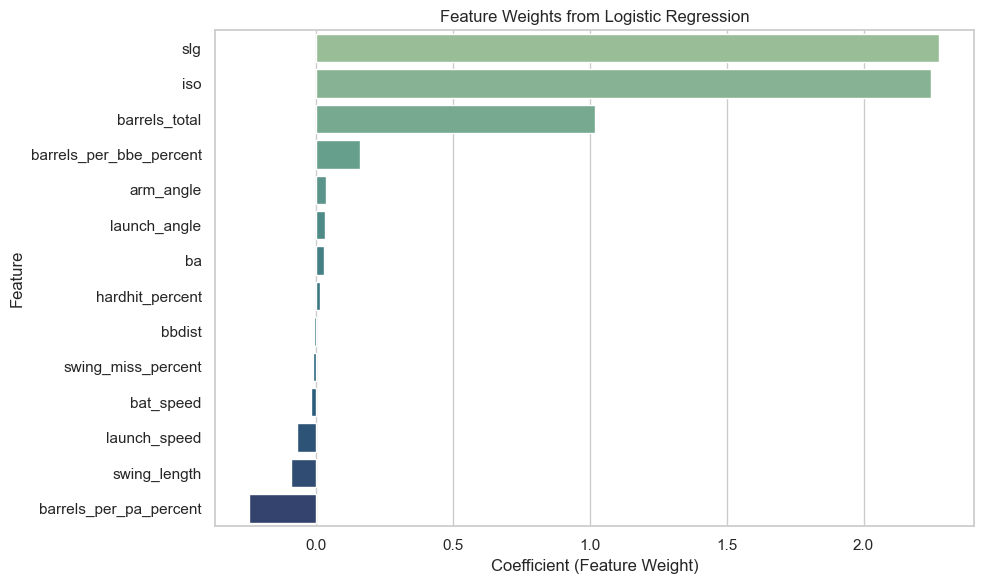

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients.values, y=coefficients.index, palette='crest')
plt.title('Feature Weights from Logistic Regression')
plt.xlabel('Coefficient (Feature Weight)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
plt.savefig("coefficient.png")  

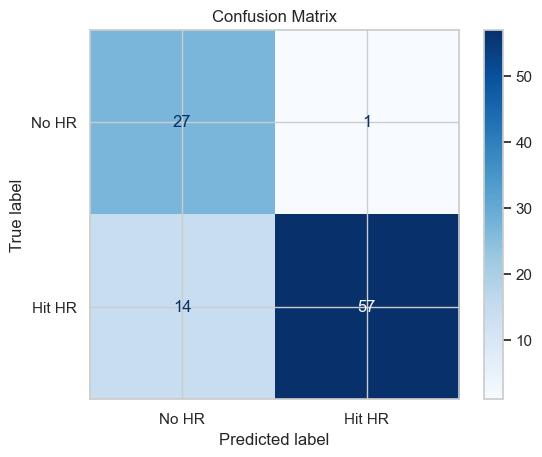

<Figure size 640x480 with 0 Axes>

In [ ]:
y_pred = model.predict(x_test)  # Replace with your prediction
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No HR', 'Hit HR'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
plt.savefig("confusion_matrix.png")  

## 🧠 

The logical regression model trained in this project aimed to classify whether a would hit at least one home run based on swing-related metrics. 

**Visualizations such as boxplots and correlation heatmaps** helped us:
- Understand how features like `barrels_total`, `iso`, and `launch_speed` relate to home run outcomes
- Identify which features had strong predictive power
- Reveal variability and outliers in swing mechanics (e.g., launch angle)

The model achieved **85% accuracy**, with strong precision (0.98) for predicting home run hitters. 
This means that when the model predicts a player will hit a home run, it's usually correct. 

**Feature importance (via model coefficients)** confirmed that:
- The model heavily relies on power/contact metrics like `barrels_total` and `iso`
- Other features, such as `swing_miss_percent`, contributed very little to predictions

Together, these results show how Statcast data can be used to build meaningful insights around player performance using machine learning.

## Summary 

This project used statcast data in order to build a binary classifcation model that predicts whether a player will hit at least one homerun this season.

## Key Features: 
- Launch Speed
- Launch Angle
- Bat Speed
- Barrel Rate
- ISO (Isolated Power)
- Distance of Batted Balls

## Work: 
- Performed data cleaning and exploratory analysis (EDA)
- Visualized feature distributions, correlations, and outliers
- Built and evaluated a lofistic regression model
- Analyzed feature importance to interpret model behavior

## Model Preformance
- **Accuracy:** 85%
- **Precision (HR class):** 0.98
- **Top Predictive Features:** `barrels_total`, `iso`, `barrels_per_pa_percent`

## Takeway : 

Power metrics like barrel rate and ISO are strong predictors of homerun success. Uncovering actionable insights to help baseball reach it's peak offensive preformance and rating preformance like the 90's 

